In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylops

from typing import Dict, Optional

In [2]:
im = np.load('../testdata/python.npy')[::20, ::20, 0]

Nz, Nx = im.shape

# Blurring guassian operator
nh = [15, 25]
hz = np.exp(-0.1*np.linspace(-(nh[0]//2), nh[0]//2, nh[0])**2)
hx = np.exp(-0.03*np.linspace(-(nh[1]//2), nh[1]//2, nh[1])**2)
hz /= np.trapz(hz) # normalize the integral to 1
hx /= np.trapz(hx) # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

(-0.5, 24.5, 14.5, -0.5)

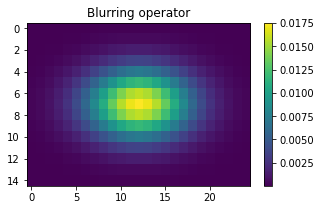

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title('Blurring operator')
fig.colorbar(him, ax=ax)
ax.axis('tight')

In [4]:
Cop = pylops.signalprocessing.Convolve2D(Nz * Nx, h=h,
                                         offset=(nh[0] // 2,
                                                 nh[1] // 2),
                                         dims=(Nz, Nx), dtype='float32')
Cop

<1024x1024 ConvolveND with dtype=float32>

In [5]:
trace_true = np.trace(Cop.todense())
trace_true

17.95143961121792

In [54]:
from itertools import chain
from numpy.linalg import pinv

def trace_estimator(L, n_samples, n_batches=10, method = 'montecarlo', options = None):
    n, m = L.shape
    dtype = L.dtype
    if n != m:
        L = L.T @ T # m x m

    n_missing = n_samples - n_batches * (n_samples // n_batches)
    batch_range = chain((n_batches for _ in range(0, n_samples - n_missing, n_batches)),
                        (n_missing for _ in range(int(n_missing != 0))))
    if options is None:
        options = {}

    sampler = options.get('sampler', 'rademacher')
    
    trace = np.zeros(1, dtype=L.dtype)[0]    
    if method == 'montecarlo':
        if sampler == 'gaussian':
            for batch in batch_range:
                z = np.random.randn(m, batch).astype(dtype)
                trace += np.trace((z.T @ (L @ z)))
            trace /= n_samples
        elif sampler == 'rayleigh':
            for batch in batch_range:
                z = np.random.randn(m, batch).astype(dtype)
                for i in range(batch):
                    z[:, i] *= m / np.dot(z[:, i].T, z[:, i])
                trace += np.trace((z.T @ (L @ z)))
            trace /= n_samples
        elif sampler == 'rademacher':
            for batch in batch_range:
                z = 2 * np.random.binomial(1, 0.5, size=(m, batch)).astype(dtype) - 1
                trace += np.trace((z.T @ (L @ z)))
            trace /= n_samples
        elif sampler == 'unitrandom':
            unit_vectors = list(range(m))
            for batch in batch_range:
                z = np.zeros((n, batch), dtype=dtype)
                unit_batch_idx = np.random.choice(unit_vectors, batch, replace=False)
                for i, idx in enumerate(unit_batch_idx):
                    z[idx, i] = 1.0 
                    unit_vectors.remove(idx)
                trace += np.trace((z.T @ (L @ z)))
            trace *= m / n_samples
        else:
            raise NotImplementedError(f"Sampler '{sampler}' not supported with '{method}' method")            
    elif method == 'hutch++':
        batch = n_samples // 3
        if sampler == 'gaussian':
            S = np.random.randn(m, batch).astype(dtype)
            G = np.random.randn(m, batch).astype(dtype)
        elif sampler == 'rayleigh':
            S = np.random.randn(m, batch).astype(dtype)
            G = np.random.randn(m, batch).astype(dtype)            
            for i in range(batch):
                S[:, i] *= m / np.dot(S[:, i].T, S[:, i])
                G[:, i] *= m / np.dot(G[:, i].T, G[:, i])
        elif sampler == 'rademacher':
            S = 2 * np.random.binomial(1, 0.5, size=(m, batch)).astype(dtype) - 1
            G = 2 * np.random.binomial(1, 0.5, size=(m, batch)).astype(dtype) - 1
        else:
            raise NotImplementedError(f"Sampler '{sampler}' not supported with '{method}' method")

        Q, _ = np.linalg.qr(L @ S)
        del S
        G = G - Q @ (Q.T @ G)
        trace += np.trace(Q.T @ (L @ Q)) + np.trace(G.T @ (L @ G)) / batch
    elif method == 'nahutch++':
        c1 = options.get("c1", 1.0 / 6.0)
        c2 = options.get("c2", 1.0 / 3.0)
        c3 = 1.0 - c1 - c2
        
        batch1 = int(np.round(n_samples * c1))
        batch2 = int(np.round(n_samples * c2))
        batch3 = n_samples - batch1 - batch2
        if batch1 == 0 or batch2 == 0 or batch3 == 0:
            msg = f"Sampler '{sampler}' not supported with {n_samples} samples."
            msg += " Try increasing it."
            raise NotImplementedError(msg)
        if sampler == 'gaussian':
            R = np.random.randn(m, batch1).astype(dtype)
            S = np.random.randn(m, batch2).astype(dtype)
            G = np.random.randn(m, batch3).astype(dtype)
        elif sampler == 'rayleigh':
            R = np.random.randn(m, batch1).astype(dtype)
            S = np.random.randn(m, batch2).astype(dtype)
            G = np.random.randn(m, batch3).astype(dtype)            
            for i in range(batch1):
                R[:, i] *= m / np.dot(R[:, i].T, R[:, i])
            for i in range(batch2):
                S[:, i] *= m / np.dot(S[:, i].T, S[:, i])
            for i in range(batch3):
                G[:, i] *= m / np.dot(G[:, i].T, G[:, i])
        elif sampler == 'rademacher':
            R = 2 * np.random.binomial(1, 0.5, size=(m, batch1)).astype(dtype) - 1
            S = 2 * np.random.binomial(1, 0.5, size=(m, batch2)).astype(dtype) - 1
            G = 2 * np.random.binomial(1, 0.5, size=(m, batch3)).astype(dtype) - 1
        else:
            raise NotImplementedError(f"Sampler '{sampler}' not supported with '{method}' method")
        Z = L @ R
        Wt = (L @ S).T
        Y = pinv(S.T @ Z)

        trace += np.trace(Y @ Wt @ Z)
        trace += (np.trace(G.T @ (L @ G)) - np.trace(G.T @ Z @ Y @ Wt @ G)) / batch3

    return trace

In [7]:
trace_estimator(Cop, Cop.shape[0]//10, method = "nahutch++", options={"sampler": "rademacher"})

17.783861396513526

In [30]:
import pandas as pd
from tqdm.notebook import tqdm

In [10]:
m = Cop.shape[1]
n_realizations = m // 10
samples = np.round(np.logspace(0.5, np.log10(m), num=15)).astype(int)
samplers = ['gaussian', 'rayleigh', 'rademacher', 'unitrandom']

results = {}

for sampler in tqdm(samplers):
    means = []
    stds = []
    errors = np.zeros(n_realizations)
    for i, n_samples in enumerate(tqdm(samples, leave=False)):
        for i, _ in enumerate(tqdm(errors, leave=False)):
            errors[i] = trace_estimator(Cop, n_samples, method='montecarlo', options={'sampler': sampler})
        means.append(np.mean(errors))
        stds.append(np.std(errors))
    results[sampler.title() + '_Mean'] = means
    results[sampler.title() + '_Std'] = stds

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

In [29]:
df_mc = pd.DataFrame(data={'Samples': 100 * samples.astype(float) / m,
                                   **results})
df_mc.columns = [c.title() for c in df_mc.columns]
for c in df_mc.columns:
    if 'Mean' in c:
        err_col = c.split('_')[0] + '_Error'
        df_mc[err_col]  = 100 * np.abs((df_mc[c] - trace_true) / trace_true)
    if 'Std' in c:
        err_col = c.split('_')[0] + '_NormStd'
        df_mc[err_col]  = 100 * df_mc[c] / trace_true
df_mc.head(2)

,Samples,Gaussian_Mean,Gaussian_Std,Rayleigh_Mean,Rayleigh_Std,Rademacher_Mean,Rademacher_Std,Unitrandom_Mean,Unitrandom_Std,Gaussian_Error,Gaussian_NormStd,Rayleigh_Error,Rayleigh_NormStd,Rademacher_Error,Rademacher_NormStd,Unitrandom_Error,Unitrandom_NormStd
0,0.292969,17.968381,2.138824,17.695528,2.224687,18.318652,2.091435,17.95144,2.428825e-07,0.094371,11.914496,1.425576,12.392808,2.045590,11.650513,4.066668e-08,1.352997e-06
1,0.488281,18.009747,1.788548,17.946541,1.739977,17.634370,1.677132,17.95144,1.678135e-07,0.324805,9.963259,0.027290,9.692688,1.766261,9.342604,5.893125e-08,9.348193e-07


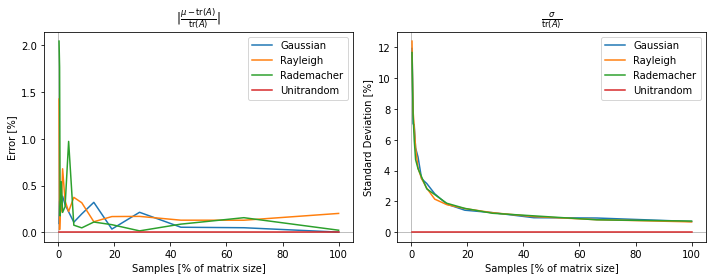

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axhline(0, c='gray', lw=0.5)
ax[0].axvline(0, c='gray', lw=0.5)
ax[1].axhline(0, c='gray', lw=0.5)
ax[1].axvline(0, c='gray', lw=0.5)
for c in df_mc.columns:
    label = c.split('_')[0].title()
    if 'Error' in c:
        df_mc.plot(x='Samples', y=c, ax=ax[0], label=label)
    if 'NormStd' in c:
        df_mc.plot(x='Samples', y=c, ax=ax[1], label=label)
ax[0].set(xlabel='Samples [% of matrix size]',
          ylabel='Error [%]',
          title=r'$\left| \frac{\mu - \operatorname{tr}(A)}{\operatorname{tr}(A)}\right|$')
ax[1].set(xlabel='Samples [% of matrix size]',
          ylabel='Standard Deviation [%]',
          title=r'$\frac{\sigma}{\operatorname{tr}(A)}$')
fig.tight_layout()

In [35]:
m = Cop.shape[1]
n_realizations = m // 10
samples = np.round(np.logspace(0.5, np.log10(m), num=15)).astype(int)
samplers = ['gaussian', 'rayleigh', 'rademacher']

results = {}

for sampler in tqdm(samplers):
    means = []
    stds = []
    errors = np.zeros(n_realizations)
    for i, n_samples in enumerate(tqdm(samples, leave=False)):
        for i, _ in enumerate(tqdm(errors, leave=False)):
            errors[i] = trace_estimator(Cop, n_samples, method='hutch++', options={'sampler': sampler})
        means.append(np.mean(errors))
        stds.append(np.std(errors))
    results[sampler.title() + '_Mean'] = means
    results[sampler.title() + '_Std'] = stds

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

In [36]:
df_hpp = pd.DataFrame(data={'Samples': 100 * samples.astype(float) / m,
                           **results})
for c in df_hpp.columns:
    if 'Mean' in c:
        err_col = c.split('_')[0] + '_Error'
        df_hpp[err_col]  = 100 * np.abs((df_hpp[c] - trace_true) / trace_true)
    if 'Std' in c:
        err_col = c.split('_')[0] + '_NormStd'
        df_hpp[err_col]  = 100 * df_hpp[c] / trace_true
df_hpp.head(2)

,Samples,Gaussian_Mean,Gaussian_Std,Rayleigh_Mean,Rayleigh_Std,Rademacher_Mean,Rademacher_Std,Gaussian_Error,Gaussian_NormStd,Rayleigh_Error,Rayleigh_NormStd,Rademacher_Error,Rademacher_NormStd
0,0.292969,17.966718,3.14080,17.895821,3.595997,17.953798,3.788096,0.085110,17.496092,0.309829,20.031804,0.013137,21.101909
1,0.488281,18.237828,3.70198,18.258028,4.022707,17.878706,3.567397,1.595352,20.622188,1.707874,22.408826,0.405170,19.872482


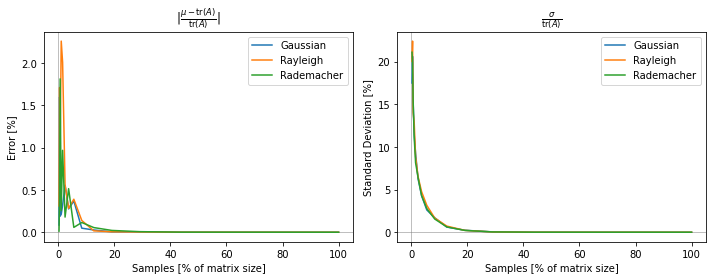

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axhline(0, c='gray', lw=0.5)
ax[0].axvline(0, c='gray', lw=0.5)
ax[1].axhline(0, c='gray', lw=0.5)
ax[1].axvline(0, c='gray', lw=0.5)
for c in df_hpp.columns:
    label = c.split('_')[0].title()
    if 'Error' in c:
        df_hpp.plot(x='Samples', y=c, ax=ax[0], label=label)
    if 'NormStd' in c:
        df_hpp.plot(x='Samples', y=c, ax=ax[1], label=label)
ax[0].set(xlabel='Samples [% of matrix size]',
          ylabel='Error [%]',
          title=r'$\left| \frac{\mu - \operatorname{tr}(A)}{\operatorname{tr}(A)}\right|$')
ax[1].set(xlabel='Samples [% of matrix size]',
          ylabel='Standard Deviation [%]',
          title=r'$\frac{\sigma}{\operatorname{tr}(A)}$')
fig.tight_layout()

In [55]:
m = Cop.shape[1]
n_realizations = m // 10
samples = np.round(np.logspace(0.7, np.log10(m), num=15)).astype(int)
samplers = ['gaussian', 'rayleigh', 'rademacher']

results = {}

for sampler in tqdm(samplers):
    means = []
    stds = []
    errors = np.zeros(n_realizations)
    for i, n_samples in enumerate(tqdm(samples, leave=False)):
        for i, _ in enumerate(tqdm(errors, leave=False)):
            errors[i] = trace_estimator(Cop, n_samples, method='nahutch++', options={'sampler': sampler})
        means.append(np.mean(errors))
        stds.append(np.std(errors))
    results[sampler.title() + '_Mean'] = means
    results[sampler.title() + '_Std'] = stds

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

In [56]:
df_na = pd.DataFrame(data={'Samples': 100 * samples.astype(float) / m,
                           **results})
for c in df_na.columns:
    if 'Mean' in c:
        err_col = c.split('_')[0] + '_Error'
        df_na[err_col]  = 100 * np.abs((df_na[c] - trace_true) / trace_true)
    if 'Std' in c:
        err_col = c.split('_')[0] + '_NormStd'
        df_na[err_col]  = 100 * df_na[c] / trace_true
df_na.head(2)

,Samples,Gaussian_Mean,Gaussian_Std,Rayleigh_Mean,Rayleigh_Std,Rademacher_Mean,Rademacher_Std,Gaussian_Error,Gaussian_NormStd,Rayleigh_Error,Rayleigh_NormStd,Rademacher_Error,Rademacher_NormStd
0,0.488281,18.136385,5.018241,18.142947,3.691964,18.419882,5.374232,1.030254,27.954533,1.066810,20.566393,2.609499,29.937609
1,0.683594,18.452210,3.032953,17.523746,4.808187,17.865260,2.843724,2.789584,16.895317,2.382503,26.784408,0.480070,15.841205


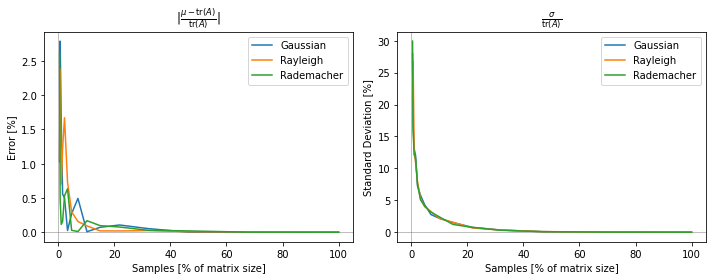

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axhline(0, c='gray', lw=0.5)
ax[0].axvline(0, c='gray', lw=0.5)
ax[1].axhline(0, c='gray', lw=0.5)
ax[1].axvline(0, c='gray', lw=0.5)
for c in df_na.columns:
    label = c.split('_')[0].title()
    if 'Error' in c:
        df_na.plot(x='Samples', y=c, ax=ax[0], label=label)
    if 'NormStd' in c:
        df_na.plot(x='Samples', y=c, ax=ax[1], label=label)
ax[0].set(xlabel='Samples [% of matrix size]',
          ylabel='Error [%]',
          title=r'$\left| \frac{\mu - \operatorname{tr}(A)}{\operatorname{tr}(A)}\right|$')
ax[1].set(xlabel='Samples [% of matrix size]',
          ylabel='Standard Deviation [%]',
          title=r'$\frac{\sigma}{\operatorname{tr}(A)}$')
fig.tight_layout()

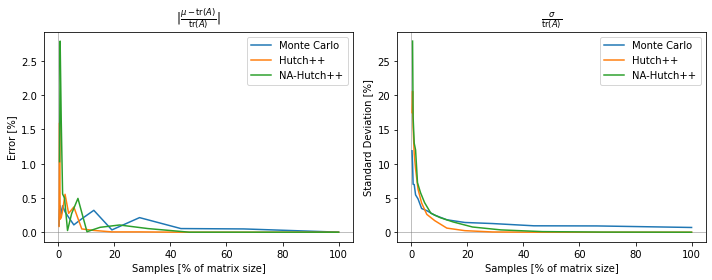

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].axhline(0, c='gray', lw=0.5)
ax[0].axvline(0, c='gray', lw=0.5)
ax[1].axhline(0, c='gray', lw=0.5)
ax[1].axvline(0, c='gray', lw=0.5)
for df, label in zip([df_mc, df_hpp, df_na], ['Monte Carlo', 'Hutch++', 'NA-Hutch++']):
    df.plot(x='Samples', y='Gaussian_Error', ax=ax[0], label=label)
    df.plot(x='Samples', y='Gaussian_NormStd', ax=ax[1], label=label)
ax[0].set(xlabel='Samples [% of matrix size]',
          ylabel='Error [%]',
          title=r'$\left| \frac{\mu - \operatorname{tr}(A)}{\operatorname{tr}(A)}\right|$')
ax[1].set(xlabel='Samples [% of matrix size]',
          ylabel='Standard Deviation [%]',
          title=r'$\frac{\sigma}{\operatorname{tr}(A)}$')
fig.tight_layout()